In [1]:
from keras.models import load_model

# load all created models first!

#model_transfer_simple_1 = load_model('Transfer_learning_multi_scale_simple_avg_1_MODEL.h5')
model_convolution_merged_1 = load_model('Convolution_multi_scale_final_merged_MODEL.h5')
#model_transfer_simple_2 = load_model('Transfer_learning_multi_scale_simple_avg_2_MODEL.h5')
model_merged_transfer = load_model('Merged_transfer_multi_scale_MODEL.h5')




Using TensorFlow backend.


### Above, we load the model from our saved models

We had saved 6 models locally - 
- 2 that we use here (model_convolution_merged_1 and model_merged_transfer) . Both these models are formed as a single model which takes 2 inputs and gives one output. Inputs are basically a sample from zoomed in image and corresponding sample from zoomed out. This is done to capture both the context and detail as described in the paper.
In this notebook, we focus on these models.
- We have neglected the other 4 here. Basically they comprised of 2 separate models - one for the zoomed in level and one for the zoomed out level in case of transfer learning and convolution models. We planned to simply take the average of the predictions from the 2 models initially, but later switched to the data generator approach.

### General methodology carried out for the results

We primarily are testing for 3 slides. First, we run tests for transfer learning merged model and then for convolution merged model.

For each model, for each image -
* we extract test patches
* calculate predictions, generate predicted mask and plot it
* calculate the metrics
* Then we plot the original mask
* The final thing is an image overlay to see the heat map as per the predicted mask

## Evaluation metrics used

The metrics we chose to focus on were accuracy, ROC, recall. In general, we have preferred a better recall over the precision. 

ROC - Higher value signifies how well our model is able to discriminate between the two classes. This is important as we want our model to identify what a tumor looks like and what a healthy cell looks like separately and properly

Precision, recall and F1- Since we do run experiments with the skewed datasets too, these are good measure. We have given preference to a higher recall over precision. The main motivation for this is the motto - 'Better safe than sorry'. We feel it is more important for us to predict lesser false negatives than it is to predict lesser false positives. This is related to the potentially serious implications of cancerous tissues and the risk of a misdiagnosis for an actually affected person

Accuracy - While not super significant while testing due to skewness of the dataset, we have made the dataset balanced while feeding it to the multi scale architecture and accuracy during training/validation phase gives us a good idea of how our model is learning



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from skimage.color import rgb2gray
import h5py

### Few helper functions are written below
This is basically for test patch extraction, label assignment, slide reading and so on.

* read_slide - reads the slide into a numpy array depending on the level we select

In [3]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

* check_if_cancer -  We use this function to see if there is any cancer. We do this by seeing if any pixels in the mask are non-zero in the region we are examining (given by patch_centre)

In [4]:

def check_if_cancer(patch_mask, patch_centre):
    # detect patch size
    patch_size = patch_mask.shape[0]
    
    # get the offset to check the x*x centre
    offset = int((patch_size-patch_centre)/2)
    
    # sum the pixels in the x*x centre for the tumor mask
    sum_vals = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
    
    return sum_vals>0

* calc_metrics -  calculates above mentioned metrics

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score, confusion_matrix
def calc_metrics(y_test,predictions, threshold = 0.8):
    true_class = y_test
    pred_class = predictions
    roc_auc = roc_auc_score(np.array(true_class) == 1, pred_class)
    precision = precision_score(np.array(true_class) == 1, np.array(pred_class) >= threshold)
    recall = recall_score(np.array(true_class) == 1, np.array(pred_class) >= threshold)
    f1 = f1_score(np.array(true_class) == 1, np.array(pred_class) >= threshold)

    print('Precision score: %.3f' % precision)
    print('Recall score: %.3f' % recall)
    print('F1 score: %.3f' % f1)
    print('ROC AUC score: %.3f' % roc_auc)

    print(confusion_matrix(np.array(true_class) == 1, np.array(pred_class) >= threshold))

* get_heatmap - generates predicted mask for image as per predictions

In [6]:
def get_heatmap(test_images, predictions, model, threshold=0.9):
    width = test_images[0].level_dimensions[4][0]
    height = test_images[0].level_dimensions[4][1]

    predicted_mask = np.zeros((height, width))

    x_c = 0
    y_c = 0

    for p in predictions:
        if p > threshold:
            predicted_mask[int(y_c + (window_size / 2) - (stride / 2)):int(y_c + (window_size / 2) + (stride / 2)), 
                           int(x_c + (window_size / 2) - (stride / 2)):int(x_c + (window_size / 2) + (stride / 2))] = 1

        x_c+= stride
        if x_c > (width - window_size):
            x_c = 0
            y_c += stride
            
    return predicted_mask

In [7]:
stride = 20
window_size = 150

* get_patches_from_images_for_testing_multiple_level - Used to extract test patches and labels for the test image at 2 zoom levels!

In [8]:
def get_patches_from_images_for_testing_multiple_level(slide, mask, level_1, level_2, window_size, stride):
    mask_labels = []
    zoom_in_image_deck = []
    zoom_out_image_deck = []

    image_width = slide.level_dimensions[level_1][0]
    image_height = slide.level_dimensions[level_1][1]
    
    x_val = 0
    y_val = 0
    downsample_factor = int(slide.level_downsamples[level_1]) #2**level

    while y_val < (image_height - window_size + 1):
        
        while x_val < (image_width - window_size + 1):
            
            # slide image
            slide_region = read_slide(slide, 
                         x= (x_val+(window_size//2)) * downsample_factor, 
                         y= (y_val + (window_size//2)) * downsample_factor, 
                         level= level_1, 
                         width= window_size, 
                         height= window_size)

            # mask image
            mask_region = read_slide(mask, 
                         x= (x_val+(window_size//2)) * downsample_factor, 
                         y= (y_val + (window_size//2)) * downsample_factor, 
                         level= level_1, 
                         width= window_size, 
                         height= window_size)

            # one channel enough for mask
            mask_region = mask_region[:,:,0]
            
            cancer_present= check_if_cancer(mask_region, 50)
            
            # slide image
            slide_region_2 = read_slide(slide, 
                         x=  x_val* downsample_factor, 
                         y=   y_val * downsample_factor, 
                         level= level_2, 
                         width= window_size, 
                         height= window_size)

            # mask image
            mask_region_2 = read_slide(mask, 
                         x= x_val * downsample_factor, 
                         y= y_val * downsample_factor, 
                         level= level_2, 
                         width= window_size, 
                         height= window_size)
            mask_region_2 = mask_region_2[:,:,0]
                
            zoom_in_image_deck.append(slide_region)
            zoom_out_image_deck.append(slide_region_2)
            
            if cancer_present:
                mask_labels.append(1)
            else:
                mask_labels.append(0)
            x_val += stride
        
        # end of row, reset and move down by stride
        x_val = 0
        y_val += stride
    return zoom_in_image_deck, zoom_out_image_deck, mask_labels

* get_test_image_multiple_level - internally calls get_patches_from_images_for_testing_multiple_level, processes it to generate dataset and returns predictions

In [9]:
def get_test_image_multiple_level(test_path, test_mask_path, model):
    test_images = []
    test_masks = []

    test_images.append(open_slide(test_path))
    test_masks.append(open_slide(test_mask_path))
    #subimages, sublabels = get_patches_from_images_for_testing(test_images[0], test_masks[0], level, window_size, stride)
    zoom_in_image_deck, zoom_out_image_deck, mask_labels = get_patches_from_images_for_testing_multiple_level(test_images[0], test_masks[0], 4, 5, 150, 20)

    X1_test = []
    X2_test = []
    y_test = []

    X1_test.extend(zoom_in_image_deck)
    X2_test.extend(zoom_out_image_deck)
    y_test.extend(mask_labels)

    X1_test = np.asarray(X1_test)
    X2_test = np.asarray(X2_test)
    y_test = np.asarray(y_test)
    
    print(X1_test.shape)
    print(X2_test.shape)
    
    predictions = model.predict([X1_test, X2_test])

    test_loss, test_acc = model.evaluate([X1_test, X2_test], y_test)
    print('test acc score:', test_acc)
    return X1_test, X2_test, y_test, predictions, test_images, test_masks

* get_mask - returns numpy array of mask

In [10]:
def get_mask(slide_object, level):
    width = slide_object.level_dimensions[level][0]
    height = slide_object.level_dimensions[level][1]

    image_result = read_slide(slide_object, 
                                x=0, 
                                y=0, 
                                level=level, 
                                width=width, 
                                height=height)
    image_result = image_result[:,:,0] 
    return image_result

* ret_slide - returns numpy array of slide
* overlay_images - plots the predicted mask over the image

In [11]:
def ret_slide(slide_name):
    level = 4
    slide_object = open_slide(slide_name)
    width = slide_object.level_dimensions[4][0]
    height = slide_object.level_dimensions[4][1]

    image_result = read_slide(slide_object, 
                                x=0, 
                                y=0, 
                                level=level, 
                                width=width, 
                                height=height)
    return image_result

def overlay_images(slide_name, level, predicted_mask):
    image_result = ret_slide(slide_name)
    if "mask" in slide_name:
        image_result = image_result[:,:,0]
    
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(image_result,alpha=0.75)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)

# Results for Transfer learning merged model

### for slide 091

In [30]:
X1_test_91, X2_test_91, y_test_91, predictions_91_transfer, test_images_91, test_masks_91 = get_test_image_multiple_level('./tumor_091.tif','./tumor_091_mask.tif',model_merged_transfer)



(34056, 150, 150, 3)
(34056, 150, 150, 3)
34056/34056 [==============================] - 85s 3ms/step

In [36]:
calc_metrics(y_test_91,predictions_91_transfer)

Precision score: 0.128
Recall score: 0.614
F1 score: 0.212
ROC AUC score: 0.816
[[29162  3949]
 [  365   580]]


### Predicted Mask

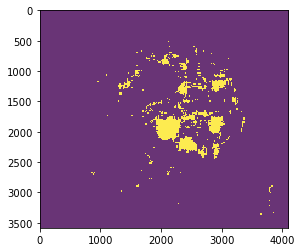

In [40]:
predicted_mask = get_heatmap(test_images_91, predictions_91_transfer, model_merged_transfer)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)



### Original Mask

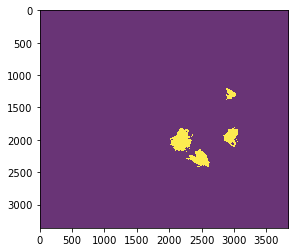

In [19]:
slide = open_slide('./tumor_091_mask.tif')
mask_region = get_mask(slide,4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Heat Map

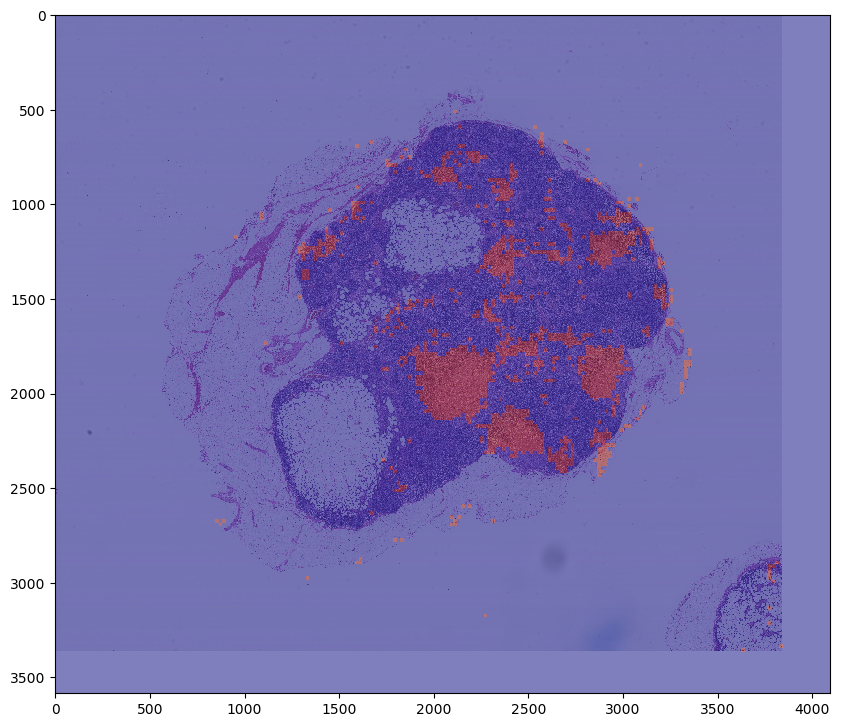

In [47]:
overlay_images('./tumor_091.tif', 4, predicted_mask)

### for slide 110

In [12]:
X1_test_110, X2_test_110, y_test_110, predictions, test_images, test_masks = get_test_image_multiple_level('./tumor_110.tif','./tumor_110_mask.tif',model_merged_transfer)

(66900, 150, 150, 3)
(66900, 150, 150, 3)
66900/66900 [==============================] - 167s 3ms/step

In [13]:
calc_metrics(y_test_110,predictions)

Precision score: 0.700
Recall score: 0.881
F1 score: 0.780
ROC AUC score: 0.948
[[47703  5264]
 [ 1652 12281]]


### Predicted Mask

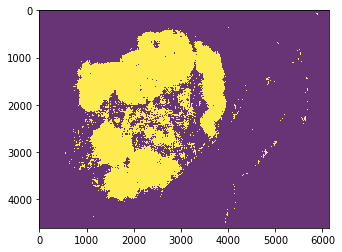

In [15]:
predicted_mask = get_heatmap(test_images, predictions, model_merged_transfer)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Original Mask

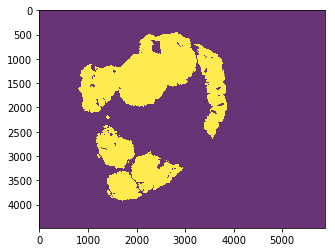

In [16]:

slide = open_slide('./tumor_110_mask.tif')
mask_region = get_mask(slide,4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)



### Heat Map

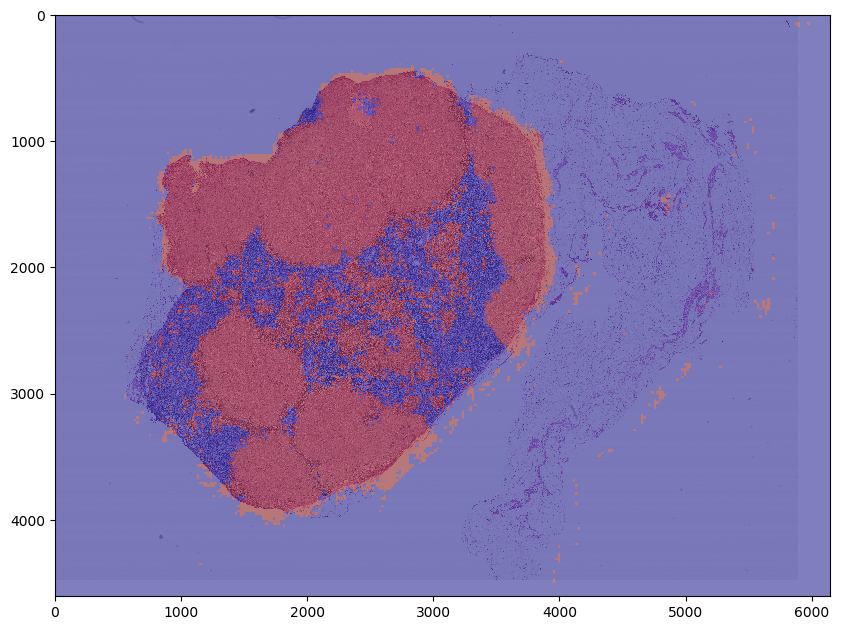

In [17]:
overlay_images('./tumor_110.tif', 4, predicted_mask)

### slide 96

In [24]:
X1_test_96, X2_test_96, y_test_96, predictions, test_images, test_masks = get_test_image_multiple_level('./tumor_096.tif','./tumor_096_mask.tif',model_merged_transfer)

(89869, 150, 150, 3)
(89869, 150, 150, 3)
89869/89869 [==============================] - 240s 3ms/step

In [28]:
calc_metrics(y_test_96,predictions)

Precision score: 0.064
Recall score: 0.396
F1 score: 0.111
ROC AUC score: 0.805
[[83388  5522]
 [  579   380]]


### Predicted mask

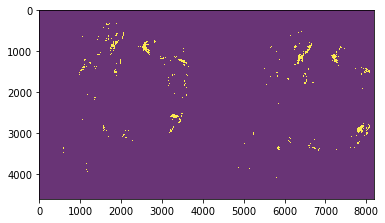

In [37]:
predicted_mask = get_heatmap(test_images, predictions, model_merged_transfer)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Original Mask

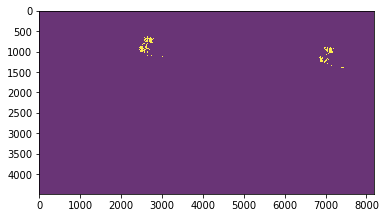

In [30]:

slide = open_slide('./tumor_096_mask.tif')
mask_region = get_mask(slide,4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)




### Heat Map

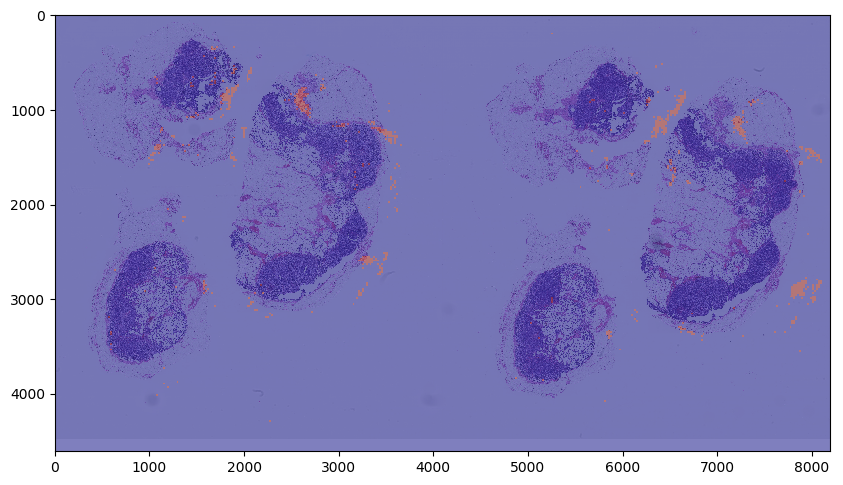

In [38]:
overlay_images('./tumor_096.tif', 4, predicted_mask)

# Results for Convolution merged model

We reuse above computed subimages here!

### For Slide 091

In [62]:
predictions = model_convolution_merged_1.predict([X1_test_91, X2_test_91])
calc_metrics(y_test_91,predictions)

Precision score: 0.085
Recall score: 0.683
F1 score: 0.151
ROC AUC score: 0.841
[[26141  6970]
 [  300   645]]


In [56]:
test_loss, test_acc = model_convolution_merged_1.evaluate([X1_test_91, X2_test_91], y_test_91)
print('test acc score:', test_acc)

34056/34056 [==============================] - 39s 1ms/step

In [51]:
test_images = []
test_images.append(open_slide('./tumor_091.tif'))

### Predicted mask

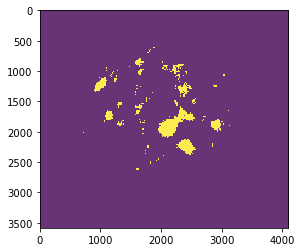

In [52]:
predicted_mask = get_heatmap(test_images, predictions, model_convolution_merged_1)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Original mask

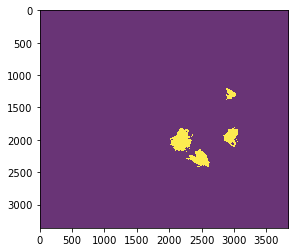

In [25]:
slide = open_slide('./tumor_091_mask.tif')
mask_region = get_mask(slide,4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Heat Map

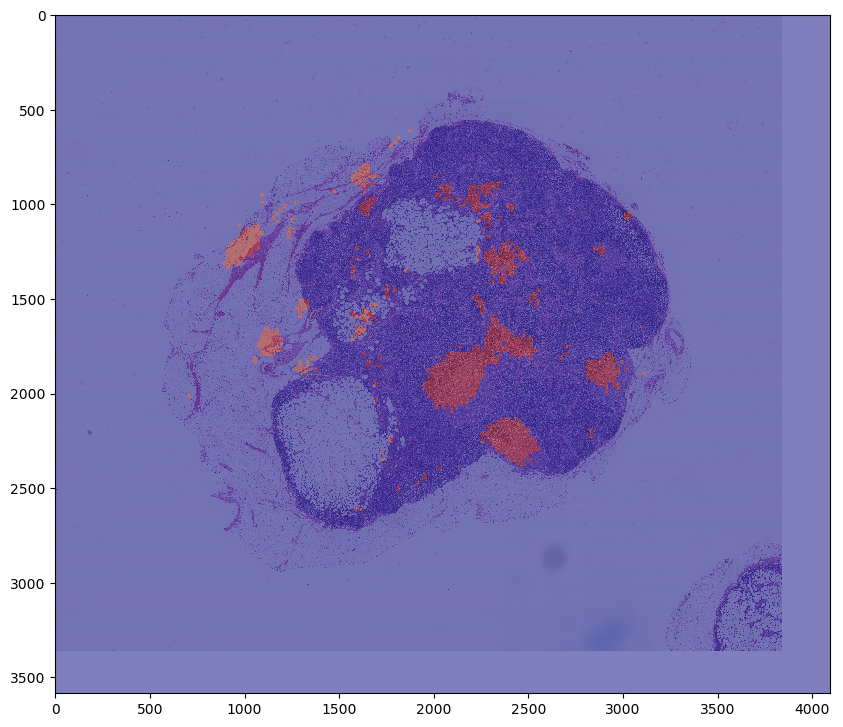

In [53]:
overlay_images('./tumor_091.tif', 4, predicted_mask)

### For Slide 110

In [18]:
predictions = model_convolution_merged_1.predict([X1_test_110, X2_test_110])
calc_metrics(y_test_110,predictions)

Precision score: 0.782
Recall score: 0.848
F1 score: 0.814
ROC AUC score: 0.960
[[49680  3287]
 [ 2117 11816]]


In [19]:
test_loss, test_acc = model_convolution_merged_1.evaluate([X1_test_110, X2_test_110], y_test_110)
print('test acc score:', test_acc)

66900/66900 [==============================] - 67s 1ms/step

In [20]:
test_images = []
test_images.append(open_slide('./tumor_110.tif'))

### Predicted Mask

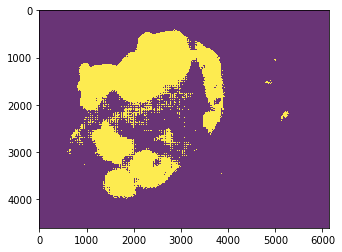

In [21]:
predicted_mask = get_heatmap(test_images, predictions, model_convolution_merged_1)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Original Mask

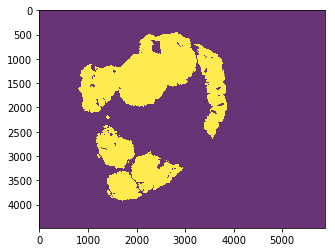

In [22]:
slide = open_slide('./tumor_110_mask.tif')
mask_region = get_mask(slide,4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

### Heat Map

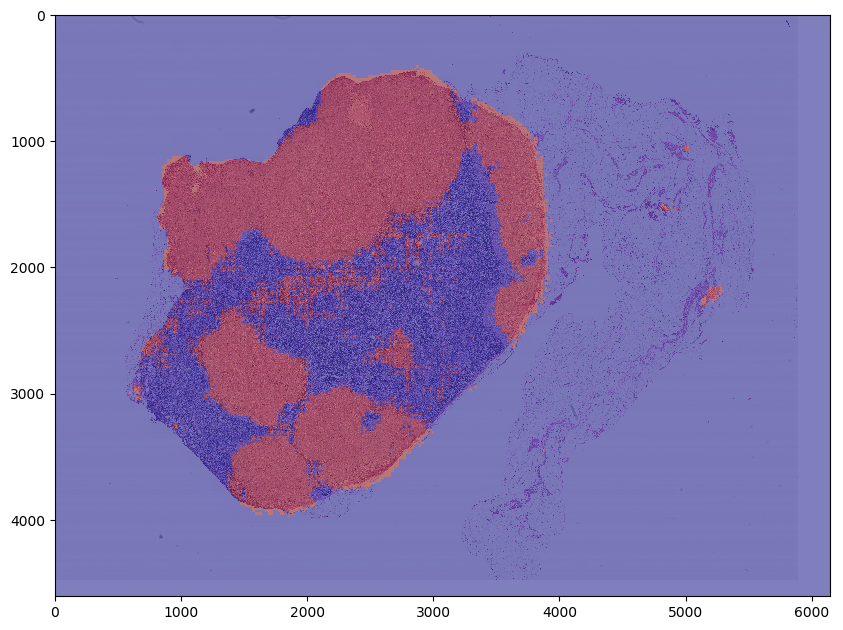

In [23]:
overlay_images('./tumor_110.tif', 4, predicted_mask)

### Slide 096

In [39]:
predictions = model_convolution_merged_1.predict([X1_test_96, X2_test_96])
calc_metrics(y_test_96,predictions)

Precision score: 0.095
Recall score: 0.369
F1 score: 0.151
ROC AUC score: 0.863
[[85537  3373]
 [  605   354]]


In [40]:
test_loss, test_acc = model_convolution_merged_1.evaluate([X1_test_96, X2_test_96], y_test_96)
print('test acc score:', test_acc)

89869/89869 [==============================] - 88s 984us/step

In [41]:
test_images = []
test_images.append(open_slide('./tumor_096.tif'))

####  Predicted Mask

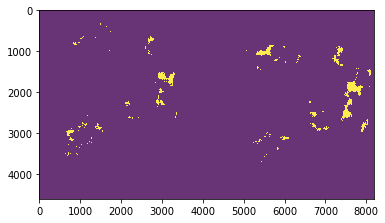

In [50]:
predicted_mask = get_heatmap(test_images, predictions, model_convolution_merged_1)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

#### Original Mask

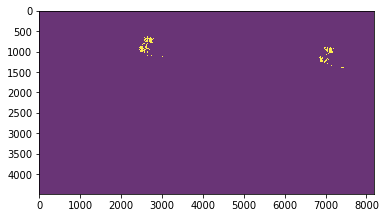

In [43]:
slide = open_slide('./tumor_096_mask.tif')
mask_region = get_mask(slide,4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

#### Heat Map

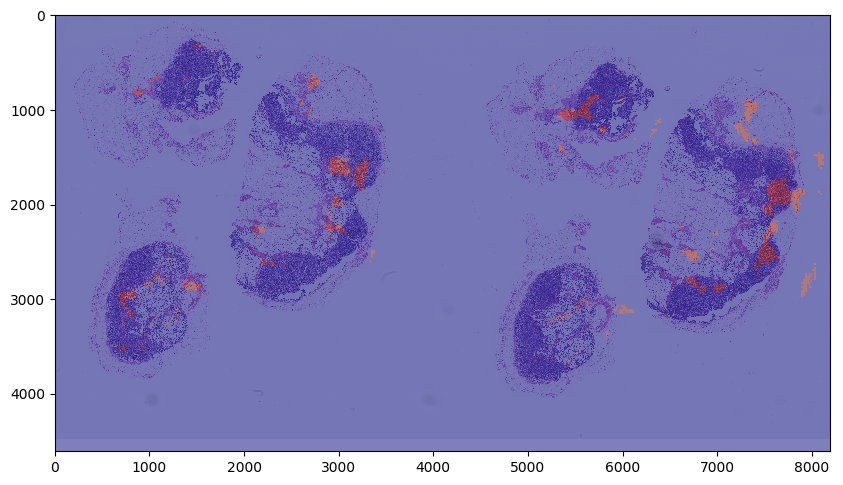

In [51]:
overlay_images('./tumor_096.tif', 4, predicted_mask)

# Summary of Experiments conducted in this project

Experiments conducted to investigate the following -
- Difference between transfer learning and Convolutional model approach : We fed same inputs to both these models both in multi scale and single scale architecture
- Difference in performance with a skewed vs balanced dataset - Since tumors were relatively fewer, We used data augmentation/randomly dropped samples to bridge the discrepancy between healthy and tumor images in the dataset.
- Difference between single scale architecture and multi scale architecture. We fed levels 4 and 5 separately to the single architecture. We compared this with performance when we feed both level 4 and 5 to the multi scale architecture
- Difference between two levels - 4 and 5 in single scale architecture
- Difference between an averaged approach - running two models and merging result in the end vs making a single model with two inputs and single outpu

# Analysis and Results


* In general, for single scale, accuracy, roc, precision and recall is better for zoomed in images
* We found that the multi scale model with levels 4 and 5 performs better than single scale model with one level
* The performance of convolution model is comparable or slightly better than the transfer learning one. In short, a huge network did not significantly increase performance
* Also, we have balanced the dataset by different techniques such as augmentation/truncating excess samples. We conducted experiments on level 5 with a single scale model. It was observed that with a more balanced dataset, the ROC, precision, Recall and accuracy improved. Also,  visibly the heat Map became better
* Our created models generally have good accuracy, ROC score and decent recall score. We have fewer False negatives - this helps in cases of critical diseases such as Cancer, where it is far more serious to say that a person does not have cancer when he actually has it versus vice versa
* Since we have trained the multi-scale on an augmented, balanced dataset for levels 4,5, it has developed a good model to identify potential tumor areas. However, as we have observed, the model generally shows more cancerous than actually present as the test set is far more skewed (few tumors, mostly healthy) than the training data the model is trained on
* Since recall and precision have a tradeoff, our model does show poor precision scores and F1 scores in cases where there is no tumor 
* We have observed that the predicted masks for our model do identify most of the cancerous regions in the original mask.

# Utility



- It could be deployed to provide a second opinion to the doctor as to where the cancerous cells are present.
- Especially since the model predicts more false positives, it helps reduce missing out on cells which might be cancerous hence decreasing the ultimate negative impact although it requires a little more work on the clinicians end.

# Future Work

- This project can be extended to employ attention mechanisms along with the current implementation of context in deep learning models which perhaps would help reduce the false positives.
- Secondly, it would be interesting to test the model on other similar large scale cancer datasets.